### Random Forest

In [1]:
import torch
import torch.nn.functional as F

from sklearn.ensemble import RandomForestRegressor

from utils import get_scenario

In [2]:
NUM_SEQUENCES = 121
SEQUENCE_STRIDE = 10

In [3]:
scenario = 1

In [4]:
train_dataset, valid_dataset, test_dataset, train_stats = get_scenario(
    scenario,
    recurrent=False,
    sequence_stride=SEQUENCE_STRIDE)

train_inputs, train_targets, train_seq_lengths = train_dataset
valid_inputs, valid_targets, valid_seq_lengths = valid_dataset
test_inputs, test_targets, test_seq_lengths = test_dataset

In [5]:
rf = RandomForestRegressor(n_estimators=200,
                           max_depth=None,
                           n_jobs=-1)

In [6]:
if train_targets.size(1) == 1:
    train_targets = train_targets.squeeze(1)
    valid_targets = valid_targets.squeeze(1)
    test_targets = test_targets.squeeze(1)

In [7]:
rf.fit(train_inputs, train_targets)

RandomForestRegressor(n_estimators=200, n_jobs=-1)

In [8]:
test_preds = torch.from_numpy(rf.predict(test_inputs))

mse_loss = F.mse_loss(test_preds, test_targets)
print('MSE Loss: {:.4f}'.format(mse_loss))

MSE Loss: 1596.1715


## Multilayer Perceptron

In [9]:
import os

from time import perf_counter

import torch
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd

from utils import get_scenario
from mlp import MLP, train_mlp

In [10]:
name = 'mlp-example'
scenario = 1

In [11]:
SEQUENCE_STRIDE = 10

BATCH_SIZE = 32
HIDDEN_SIZE = 256
NUM_HIDDEN = 2
LEARNING_RATE = 1e-3
NUM_EPOCH_CONVERGENCE = 8

In [12]:
train_dataset, valid_dataset, test_dataset, train_stats = get_scenario(
    scenario,
    recurrent=False,
    sequence_stride=SEQUENCE_STRIDE)

train_inputs, train_targets, train_lengths = train_dataset
valid_inputs, valid_targets, valid_lengths = valid_dataset
test_inputs, test_targets, test_lengths = test_dataset
mean_inputs, std_inputs, mean_targets, std_targets = train_stats

In [13]:
mlp = MLP(
    input_size=train_inputs.size(1),
    hidden_size=HIDDEN_SIZE,
    output_size=train_targets.size(1),
    num_hidden=NUM_HIDDEN,
    mean_inputs=mean_inputs,
    std_inputs=std_inputs,
    mean_targets=mean_targets,
    std_targets=std_targets)

opt = optim.Adam(mlp.parameters(), lr=LEARNING_RATE)

In [14]:
start = perf_counter()
stats = train_mlp(mlp, opt, train_inputs, train_targets, valid_inputs,
    valid_targets, BATCH_SIZE, NUM_EPOCH_CONVERGENCE)
end = perf_counter()

Epoch 001
	Train: 5488.4701
	Train after epoch: 1044.7332
	Valid: 1085.1865
Epoch 002
	Train: 714.8604
	Train after epoch: 482.0255
	Valid: 479.4556
Epoch 003
	Train: 471.7110
	Train after epoch: 393.1264
	Valid: 409.7749
Epoch 004
	Train: 285.4163
	Train after epoch: 239.2818
	Valid: 233.2660
Epoch 005
	Train: 274.0772
	Train after epoch: 146.2244
	Valid: 145.4141
Epoch 006
	Train: 258.0335
	Train after epoch: 118.6124
	Valid: 122.5223
Epoch 007
	Train: 185.9047
	Train after epoch: 105.6156
	Valid: 109.6999
Epoch 008
	Train: 177.1378
	Train after epoch: 96.2215
	Valid: 98.7793
Epoch 009
	Train: 155.9595
	Train after epoch: 143.6895
	Valid: 143.9412
Epoch 010
	Train: 165.9689
	Train after epoch: 90.5515
	Valid: 94.2821
Epoch 011
	Train: 132.6824
	Train after epoch: 99.1852
	Valid: 103.4154
Epoch 012
	Train: 134.1332
	Train after epoch: 424.2747
	Valid: 424.2205
Epoch 013
	Train: 125.0891
	Train after epoch: 161.7614
	Valid: 161.9767
Epoch 014
	Train: 115.0321
	Train after epoch: 61.796

In [15]:
os.makedirs('results/', exist_ok=True)
df = pd.DataFrame.from_dict(stats)
df.to_csv('results/{}.csv'.format(name))

print('Total CPU time {:.2f}'.format(end - start))
print('CPU time per epoch {:.2f}'.format((end - start) / len(df)))

os.makedirs('weights/', exist_ok=True)
weights_file = 'weights/{}.pth'.format(name)
torch.save(mlp.state_dict(), weights_file)

Total CPU time 320.64
CPU time per epoch 10.34


In [16]:
with torch.no_grad():
    test_preds = mlp(test_inputs)

mse_loss = F.mse_loss(test_preds, test_targets)
print('Test MSE Loss: {:.4f}'.format(mse_loss.item()))

Test MSE Loss: 51.4927


### Display MLP performance

In [17]:
import matplotlib.pyplot as plt

from utils import show_sample_sequence

In [18]:
name = 'mlp-example'
scenario = 1

In [19]:
train_dataset, valid_dataset, test_dataset, train_stats = get_scenario(
    scenario,
    recurrent=False,
    sequence_stride=SEQUENCE_STRIDE)

train_inputs, train_targets, train_lengths = train_dataset
valid_inputs, valid_targets, valid_lengths = valid_dataset
test_inputs, test_targets, test_lengths = test_dataset
mean_inputs, std_inputs, mean_targets, std_targets = train_stats

In [20]:
mlp = MLP(
    input_size=train_inputs.size(1),
    hidden_size=HIDDEN_SIZE,
    output_size=train_targets.size(1),
    num_hidden=NUM_HIDDEN,
    mean_inputs=mean_inputs,
    std_inputs=std_inputs,
    mean_targets=mean_targets,
    std_targets=std_targets)

mlp.load_state_dict(torch.load('weights/{}.pth'.format(name)))

<All keys matched successfully>

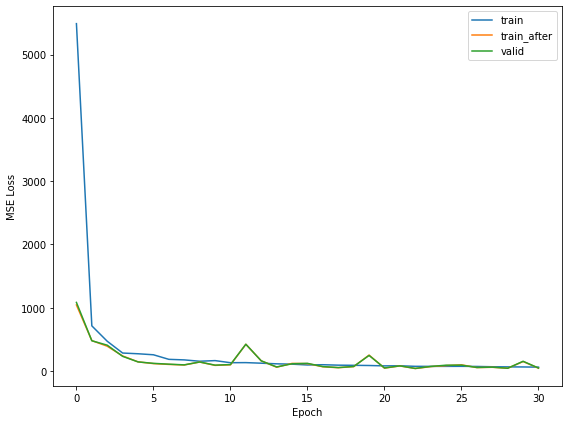

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
losses = pd.read_csv('results/{}.csv'.format(name), index_col=[0])
losses.plot(ax=ax)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
plt.tight_layout()
plt.show()

In [22]:
with torch.no_grad():
    train_preds = mlp(train_inputs)
    valid_preds = mlp(valid_inputs)
    test_preds = mlp(test_inputs)

mse_loss = F.mse_loss(train_preds, train_targets)
print('Train MSE Loss: {:,.4f}'.format(mse_loss.item()))
mse_loss = F.mse_loss(valid_preds, valid_targets)
print('Valid MSE Loss: {:,.4f}'.format(mse_loss.item()))
mse_loss = F.mse_loss(test_preds, test_targets)
print('Test MSE Loss: {:,.4f}'.format(mse_loss.item()))

Train MSE Loss: 40.3842
Valid MSE Loss: 42.5017
Test MSE Loss: 51.4927


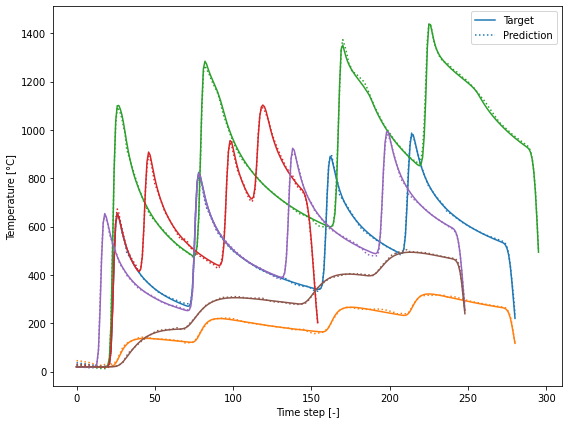

In [23]:
show_sample_sequence(test_targets, test_preds, test_lengths,
                     recurrent=False)

## Recurrent Neural Network

In [24]:
import os

from time import perf_counter

import torch
import torch.optim as optim

import pandas as pd

from utils import get_scenario
from rnn import RNN, masked_mse_loss, train_rnn

In [25]:
SEQUENCE_STRIDE = 10

BATCH_SIZE = 16
RNN_HIDDEN_SIZE = 256
MLP_HIDDEN_SIZE = 1024
NUM_LAYERS = 2
LEARNING_RATE = 1e-3
NUM_EPOCH_CONVERGENCE = 8

In [26]:
name = 'rnn-example'
scenario = 1

In [27]:
train_dataset, valid_dataset, test_dataset, train_stats = get_scenario(
    scenario,
    recurrent=True,
    sequence_stride=SEQUENCE_STRIDE)

train_inputs, train_targets, train_lengths = train_dataset
valid_inputs, valid_targets, valid_lengths = valid_dataset
test_inputs, test_targets, test_lengths = test_dataset
mean_inputs, std_inputs, mean_targets, std_targets = train_stats

In [28]:
rnn = RNN(
    cell='gru',
    input_size=train_inputs.size(2),
    rnn_hidden_size=RNN_HIDDEN_SIZE,
    mlp_hidden_size=MLP_HIDDEN_SIZE,
    output_size=train_targets.size(2),
    num_layers=NUM_LAYERS,
    mean_inputs=mean_inputs,
    std_inputs=std_inputs,
    mean_targets=mean_targets,
    std_targets=std_targets)

opt = optim.Adam(rnn.parameters(), lr=LEARNING_RATE)

In [29]:
start = perf_counter()
stats = train_rnn(rnn, opt, train_inputs, train_targets, train_lengths,
    valid_inputs, valid_targets, valid_lengths, BATCH_SIZE,
    NUM_EPOCH_CONVERGENCE)
end = perf_counter()

Epoch 001
	Train: 60,310.6332
	Train after epoch: 40,375.6211
	Valid: 38,480.8086
Epoch 002
	Train: 35,790.4216
	Train after epoch: 22,195.6855
	Valid: 21,348.4277
Epoch 003
	Train: 16,283.8312
	Train after epoch: 8,706.2314
	Valid: 8,243.2461
Epoch 004
	Train: 7,094.0444
	Train after epoch: 8,921.6230
	Valid: 8,407.8662
Epoch 005
	Train: 4,922.1088
	Train after epoch: 4,183.2656
	Valid: 4,095.7698
Epoch 006
	Train: 3,209.7766
	Train after epoch: 2,505.6399
	Valid: 2,457.8135
Epoch 007
	Train: 2,863.7768
	Train after epoch: 2,078.8625
	Valid: 2,056.6897
Epoch 008
	Train: 1,423.1493
	Train after epoch: 1,580.2595
	Valid: 1,606.7145
Epoch 009
	Train: 1,107.3742
	Train after epoch: 725.1363
	Valid: 779.6533
Epoch 010
	Train: 847.6909
	Train after epoch: 766.4687
	Valid: 749.5703
Epoch 011
	Train: 500.1582
	Train after epoch: 338.4492
	Valid: 360.2276
Epoch 012
	Train: 355.1302
	Train after epoch: 252.5502
	Valid: 264.6776
Epoch 013
	Train: 248.5029
	Train after epoch: 642.4884
	Valid: 639

In [30]:
os.makedirs('results/', exist_ok=True)
df = pd.DataFrame.from_dict(stats)
df.to_csv('results/{}.csv'.format(name))

print('Total CPU time {:.2f}'.format(end - start))
print('CPU time per epoch {:.2f}'.format((end - start) / len(df)))

os.makedirs('weights/', exist_ok=True)
weights_file = 'weights/{}.pth'.format(name)
torch.save(rnn.state_dict(), weights_file)

Total CPU time 836.32
CPU time per epoch 20.40


In [31]:
with torch.no_grad():
    test_preds, _ = rnn(test_inputs)

mse_loss = masked_mse_loss(test_preds, test_targets, test_lengths,
                           test_lengths.max().item())
print('Test MSE Loss: {:,.4f}'.format(mse_loss.item()))

Test MSE Loss: 70.0489


### Display RNN performance

In [32]:
import matplotlib.pyplot as plt

from utils import show_sample_sequence

In [33]:
name = 'rnn-example'
scenario = 1

In [34]:
train_dataset, valid_dataset, test_dataset, train_stats = get_scenario(
    scenario,
    recurrent=True,
    sequence_stride=SEQUENCE_STRIDE)

train_inputs, train_targets, train_lengths = train_dataset
valid_inputs, valid_targets, valid_lengths = valid_dataset
test_inputs, test_targets, test_lengths = test_dataset
mean_inputs, std_inputs, mean_targets, std_targets = train_stats

In [35]:
rnn = RNN(
    cell='gru',
    input_size=train_inputs.size(2),
    rnn_hidden_size=RNN_HIDDEN_SIZE,
    mlp_hidden_size=MLP_HIDDEN_SIZE,
    output_size=train_targets.size(2),
    num_layers=NUM_LAYERS,
    mean_inputs=mean_inputs,
    std_inputs=std_inputs,
    mean_targets=mean_targets,
    std_targets=std_targets)

rnn.load_state_dict(torch.load('weights/{}.pth'.format(name)))

<All keys matched successfully>

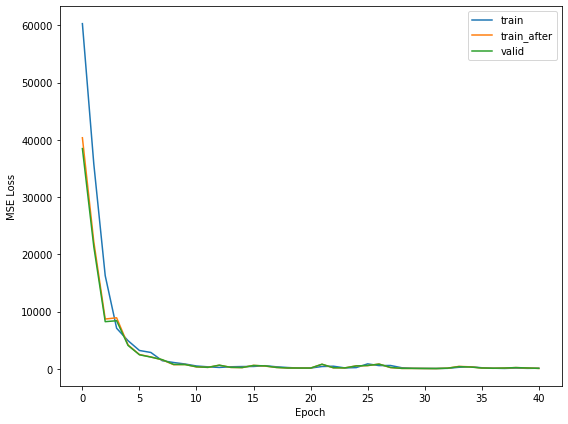

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
losses = pd.read_csv('results/{}.csv'.format(name), index_col=[0])
losses.plot(ax=ax)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
plt.tight_layout()
plt.show()

In [37]:
with torch.no_grad():
    train_preds, _ = rnn(train_inputs)
    valid_preds, _ = rnn(valid_inputs)
    test_preds, _ = rnn(test_inputs)

mse_loss = masked_mse_loss(train_preds, train_targets, train_lengths,
                           train_lengths.max().item())
print('Train MSE Loss: {:,.4f}'.format(mse_loss.item()))
mse_loss = masked_mse_loss(valid_preds, valid_targets, valid_lengths,
                           valid_lengths.max().item())
print('Valid MSE Loss: {:,.4f}'.format(mse_loss.item()))
mse_loss = masked_mse_loss(test_preds, test_targets, test_lengths,
                           test_lengths.max().item())
print('Test MSE Loss: {:,.4f}'.format(mse_loss.item()))

Train MSE Loss: 52.9409
Valid MSE Loss: 57.2228
Test MSE Loss: 70.0489


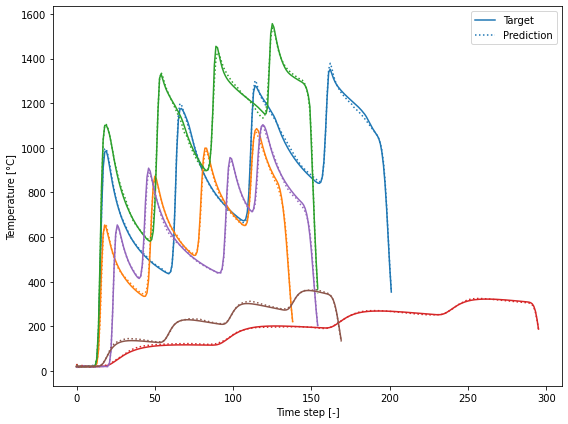

In [38]:
show_sample_sequence(test_targets, test_preds, test_lengths,
                     recurrent=True)